In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract

In [2]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\mirevecod\AppData\Local\Tesseract-OCR\tesseract.exe'

Read the file

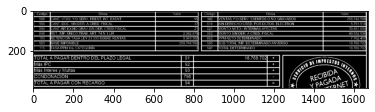

In [3]:
#read your file
file=r'./f29cv.png'
img = cv2.imread(file,0)
img.shape

#thresholding the image to a binary image
thresh,img_bin = cv2.threshold(img,128,255,cv2.THRESH_BINARY |cv2.THRESH_OTSU)

#inverting the image 
img_bin = 255-img_bin
cv2.imwrite('./cv_inverted.png',img_bin)

#Plotting the image to see the output
plotting = plt.imshow(img_bin,cmap='gray')
plt.show()

Define kernel to detect rectangular boxes

In [4]:
# Length(width) of kernel as 100th of total width
kernel_len = np.array(img).shape[1]//100

# Defining a vertical kernel to detect all vertical lines of image 
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))

# Defining a horizontal kernel to detect all horizontal lines of image
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))

# A kernel of 2x2
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

Detection of vertical lines

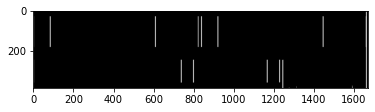

In [5]:
#Use vertical kernel to detect and save the vertical lines in a jpg
image_1 = cv2.erode(img_bin, ver_kernel, iterations=3)
vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)
cv2.imwrite("./vertical.jpg",vertical_lines)

#Plot the generated image
plotting = plt.imshow(image_1,cmap='gray')
plt.show()

Detection of horizontal lines

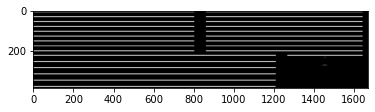

In [6]:
#Use horizontal kernel to detect and save the horizontal lines in a jpg
image_2 = cv2.erode(img_bin, hor_kernel, iterations=3)
horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)
cv2.imwrite("./horizontal.jpg",horizontal_lines)

#Plot the generated image
plotting = plt.imshow(image_2,cmap='gray')
plt.show()

Combining horizontal and vertical lines to third image

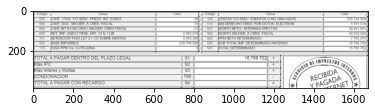

In [7]:
# Combine horizontal and vertical lines in a new third image, with both having same weight.
img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)

# Eroding and thesholding the image
img_vh = cv2.erode(~img_vh, kernel, iterations=2)
thresh, img_vh = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
cv2.imwrite("./img_vh.jpg", img_vh)
bitxor = cv2.bitwise_xor(img,img_vh)
bitnot = cv2.bitwise_not(bitxor)

# Plotting the generated image
plotting = plt.imshow(bitnot,cmap='gray')
plt.show()

Detect contours for following box detection

In [8]:
# Detect contours for following box detection
contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

The following function is necessary to get a sequence of the contours and to sort them from top-to-bottom

In [9]:
def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

In [10]:
# Sort all the contours by top to bottom.
contours, boundingBoxes = sort_contours(contours, method="top-to-bottom")

Retrieve the cells position

In [11]:
#Creating a list of heights for all detected boxes
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]

#Get mean of heights
mean = np.mean(heights)

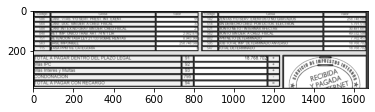

In [12]:
#Create list box to store all boxes in  
box = []

# Get position (x,y), width and height for every contour and show the contour on image
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if (w<1000 and h<500):
        image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        box.append([x,y,w,h])
plotting = plt.imshow(image,cmap='gray')
plt.show()

In [13]:
# Creating two lists to define row and column in which cell is located
row=[]
column=[]
j=0

# Sorting the boxes to their respective row and column
for i in range(len(box)):
    if(i==0):
        column.append(box[i])
        previous=box[i]
    else:
        if(box[i][1]<=previous[1]+mean/2):
            column.append(box[i])
            previous=box[i]
            if(i==len(box)-1):
                row.append(column)
        else:
            row.append(column)
            column=[]
            previous = box[i]
            column.append(box[i])
print(column)
print(row)

[[1173, 351, 56, 25], [805, 351, 362, 25], [744, 351, 55, 25], [7, 351, 731, 25]]
[[[1668, 0, 4, 386], [1452, 13, 209, 18], [927, 13, 519, 18], [845, 13, 76, 18], [615, 13, 208, 18], [90, 13, 519, 18], [7, 13, 77, 18]], [[1452, 37, 209, 18], [927, 37, 519, 18], [845, 37, 76, 18], [615, 37, 208, 18], [90, 37, 519, 18], [7, 37, 77, 18]], [[1452, 61, 209, 18], [927, 61, 519, 18], [845, 61, 76, 18], [615, 61, 208, 18], [90, 61, 519, 18], [7, 61, 77, 18]], [[1452, 85, 209, 18], [927, 85, 519, 18], [845, 85, 76, 18], [615, 85, 208, 18], [90, 85, 519, 18], [7, 85, 77, 18]], [[1452, 109, 209, 18], [927, 109, 519, 18], [845, 109, 76, 18], [615, 109, 208, 18], [90, 109, 519, 18], [7, 109, 77, 18]], [[1452, 133, 209, 18], [927, 133, 519, 18], [845, 133, 76, 18], [615, 133, 208, 18], [90, 133, 519, 18], [7, 133, 77, 18]], [[1452, 157, 209, 19], [927, 157, 519, 19], [845, 157, 76, 19], [615, 157, 208, 19], [90, 157, 519, 19], [7, 157, 77, 19]], [[1452, 181, 209, 19], [927, 181, 519, 19], [845, 181,

In [14]:
# Calculating maximum number of cells
countcol = 0
for i in range(len(row)):
    countcol = len(row[i])
    if countcol > countcol:
        countcol = countcol

In [15]:
# Retrieving the center of each column
center = [int(row[i][j][0]+row[i][j][2]/2) for j in range(len(row[i])) if row[0]]
center=np.array(center)
center.sort()

In [16]:
# Regarding the distance to the columns center, the boxes are arranged in respective order
finalboxes = []
for i in range(len(row)):
    lis=[]
    for k in range(countcol):
        lis.append([])
    for j in range(len(row[i])):
        diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
        minimum = min(diff)
        indexing = list(diff).index(minimum)
        lis[indexing].append(row[i][j])
    finalboxes.append(lis)

Extract values

In [17]:
# From every single image-based cell/box the strings are extracted via pytesseract and stored in a list
outer=[]
for i in range(len(finalboxes)):
    
    for j in range(len(finalboxes[i])):
        inner=''
        
        if(len(finalboxes[i][j])==0):
            outer.append(' ')
            
        else:
            
            for k in range(len(finalboxes[i][j])):
                y,x,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                finalimg = bitnot[x:x+h, y:y+w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(finalimg,2,2,2,2, cv2.BORDER_CONSTANT,value=[255,255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dilation = cv2.dilate(resizing, kernel,iterations=1)
                erosion = cv2.erode(dilation, kernel,iterations=2)
                
                out = pytesseract.image_to_string(erosion)
                if(len(out)==0):
                    out = pytesseract.image_to_string(erosion, config='--psm 3')
                    
                inner = inner +" "+ out
            outer.append(inner)

In [18]:
#Creating a dataframe of the generated OCR list
arr = np.array(outer)
df = pd.DataFrame(arr.reshape(len(row), countcol))
df.head()

,0,1,2,3
0,Glosa\n Codigo\n,Cédigo\n Valor\n,Glosa\n,Valor\n
1,CANT. VTAS. Y/O SERV. PREST. INT. EXENT.\n 5...,142\n 95\n,VENTAS Y/O SERV. EXENTOS O NO GRAVADOS\n,258.748.580\n
2,CANT. DOC. SIN DER. A CRED. FISCAL\n 564\n,514\n 37\n,SIN DERECHO CRED. POR DCTOS. ELECTRON.\n,5.791.518\n
3,CANT.INT.EX.NO GRAV.SIN DER. CRED.FISCAL\n 5...,521\n 21\n,MONTO NETO / INTERNAS AFECTAS\n,30.481.681\n
4,RET. IMP. UNICO TRAB. ART. 74N1LIR\n 048\n,562\n 2.062.879\n,MONTO SIN DER. A CRED. FISCAL\n,49.532.506\n


In [ ]:
# Converting it in a excel-file
filename = './output.xlsx'
writer = pd.ExcelWriter(filename, engine='xlsxwriter')

df.to_excel(writer, sheet_name='Sheet1')

writer.save()